In [99]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import scipy.stats as stats
from scipy.stats import kurtosis

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

#classification
import networkx
import community.community_louvain as community_louvain # pip install community
import igraph as ig
import cdlib
from cdlib import algorithms

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
# from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [18]:
traindf = pd.read_hdf(dir+'LouvainAnalysis/DesertPrediction.h5')

## Louvain Community Detection

In [19]:
# Helper function
def calculate_louvain_communities(assignment_matrix, node_order=None):
    # Calculate louvain communities
    G = networkx.to_networkx_graph(assignment_matrix, create_using=networkx.Graph())  
    louvain_community_dict = community_louvain.best_partition(G)
    # Convert community assignmet dict into list of communities
    louvain_comms = {}
    for node_index, comm_id in louvain_community_dict.items():
        if comm_id in louvain_comms.keys():
            louvain_comms[comm_id].append(node_index)
        else:
            louvain_comms.setdefault(comm_id, [node_index])
    nodes_louvain_ordered = [node for comm in louvain_comms.values() for node in comm]

    # reorder original matrix according to node order
    adjacency_matrix = np.zeros_like(assignment_matrix)
    for i in range(assignment_matrix.shape[0]):
        for j in range(assignment_matrix.shape[0]):
            r = nodes_louvain_ordered.index(i)
            c = nodes_louvain_ordered.index(j)
            adjacency_matrix[r,c] = assignment_matrix[i,j] 
            
    return G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix




dataframe=traindf
X=[dataframe.mc_min,dataframe.mc_max, dataframe.mc_mean, dataframe.mc_std_dev, dataframe.mc_k,
     dataframe.wf_min, dataframe.wf_max, dataframe.wf_mean, dataframe.wf_std_dev, dataframe.wf_k,
     dataframe.wd_min, dataframe.wd_max, dataframe.wd_mean, dataframe.wd_std_dev, dataframe.wd_k,
     dataframe.ma_min, dataframe.ma_max, dataframe.ma_mean, dataframe.ma_std_dev, dataframe.ma_k,
     dataframe.st_min, dataframe.st_max, dataframe.st_mean, dataframe.st_std_dev, dataframe.st_k]

REMOVE_Y_CORR = True
y=dataframe.distance

In [20]:
corr_mat = np.zeros([len(X), len(X)])
for i in range(len(X)):
    for j in range(len(X)):
        
        if not REMOVE_Y_CORR:
            result = scipy.stats.linregress(X[i], X[j])
        else:
            result_iy = scipy.stats.linregress(y, X[i])
            resid_i = X[i] - (y*result_iy.slope + result_iy.intercept)

            result_jy = scipy.stats.linregress(y, X[j])
            resid_j = X[j] - (y*result_jy.slope + result_jy.intercept)
            
            result = scipy.stats.linregress(resid_i, resid_j)
            
        corr_mat[i,j] = result.rvalue**2
        
G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix = calculate_louvain_communities(corr_mat)

In [5]:
from scipy.cluster import hierarchy

rsq_matrix=corr_mat
dist_matrix = np.sqrt(1 - rsq_matrix)
Z = hierarchy.linkage(dist_matrix, 'ward')

clusters = hierarchy.fcluster(Z, t=1.0, criterion='distance')

[13  2 16  3  6 11  1  1  1  8 12  5 18  5  9 14  4 15  4 10 12  2 17  3
  7]


In [6]:
cn=['$min(WC)$','$max(WC)$','$\mu(WC)$','$\sigma(WC)$','$WC_k$',
             '$min(WF)$','$max(WF)$','$\mu(WF)$','$\sigma(WF)$','$WF_k$',
             '$min(WD)$','$max(WD)$','$\mu(WD)$','$\sigma(WD)$','$WD_k$',
             '$min(WMA)$','$max(WMA)$','$\mu(WMA)$','$\sigma(WMA)$','$WMA_k$',
             '$min(WSD)$','$max(WSD)$','$\mu(WSD)$','$\sigma(WSD)$','$WSD_k$']

In [ ]:
### Plotting
n = []
for i in range(len(X)):
    n.append(X[i].name)

dicts = {}
keys = range(len(X))
values = n
for i in keys:
        dicts[i] = values[i]
        
new_list_label = sorted(dicts.items(), key=lambda pair: nodes_louvain_ordered.index(pair[0]))

new_list = []
for i in range(len(new_list_label)):
    new_list.append(new_list_label[i][1])
new_list.insert(0, 0)    

In [ ]:
f,(ax) = plt.subplots(1,1,figsize=(10,10))
ax.matshow(adjacency_matrix,cmap='bone_r',  aspect='auto')


ax.grid(False)
ax.set_title('Louvain')
ax.set_yticklabels(new_list)
ax.set_xticklabels(new_list,rotation=90)
ax.yaxis.set_major_locator(plt.MaxNLocator(25))
ax.xaxis.set_major_locator(plt.MaxNLocator(25))

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
f.savefig('../../Figure/louvain.jpeg', dpi=300, bbox_inches = "tight")

### Clustermap using Scipy

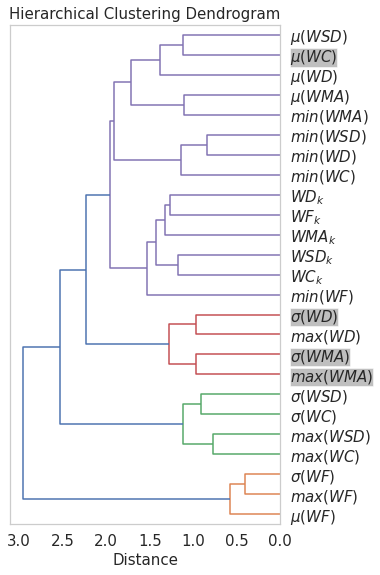

In [156]:
# Plot the dendrogram

f,ax=plt.subplots(1,1,figsize=(5, 8))
dn = hierarchy.dendrogram(Z, orientation='left')
int_list = [int(x) for x in dn['ivl']]
raesult = [cn[i] for i in int_list]
ax.set_title('Hierarchical Clustering Dendrogram')
# ax.set_xlabel('Index')
ax.set_xlabel('Distance')
ax.grid(False)

ax.set_yticklabels(result,rotation=0)
ax.get_yticklabels()[23].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
ax.get_yticklabels()[10].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
ax.get_yticklabels()[7].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
ax.get_yticklabels()[8].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/dendo.jpeg', dpi=300, bbox_inches = "tight")

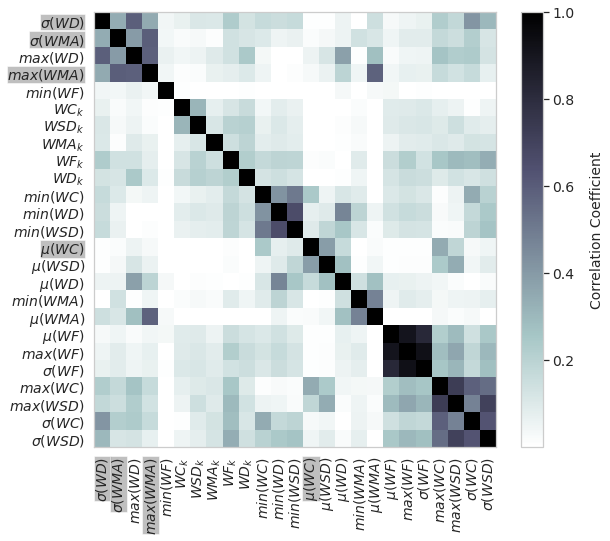

In [139]:
# Convert the ndarray to a DataFrame
corr_mat_df = pd.DataFrame(corr_mat)

# Perform hierarchical clustering
Z_row = hierarchy.linkage(corr_mat_df, method='ward')
Z_col = hierarchy.linkage(corr_mat_df.T, method='ward')

# Get the order of rows and columns based on hierarchical clustering
row_order = hierarchy.leaves_list(Z_row)
col_order = hierarchy.leaves_list(Z_col)

# Reorder the data based on clustering
ordered_data = corr_mat_df.iloc[row_order, col_order]
ordered_data.index

new_names_ = [cn[i] for i in ordered_data.index]
new_names_

# Create a Matplotlib figure
f, ax = plt.subplots(figsize=(9, 8))
ax.grid(False)
# Plot the heatmap using imshow
cax = ax.imshow(ordered_data, cmap='bone_r', aspect='auto')

# Set x-axis and y-axis labels
ax.set_xticks(np.arange(len(col_order)))
ax.set_yticks(np.arange(len(row_order)))
ax.set_xticklabels(new_names_, rotation=90)
ax.set_yticklabels(new_names_)

ax.get_xticklabels()[13].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
ax.get_xticklabels()[0].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
ax.get_xticklabels()[1].set_bbox(dict(facecolor="gray", alpha=0.5, pad=0.1))
ax.get_xticklabels()[3].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))

ax.get_yticklabels()[13].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
ax.get_yticklabels()[0].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
ax.get_yticklabels()[1].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
ax.get_yticklabels()[3].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))


# Add a colorbar
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=90, labelpad=15)
figurefirst.mpl_functions.set_fontsize(f, 14)
f.savefig('../../Figure/dendo-matrix_scipy.jpeg', dpi=300, bbox_inches = "tight")

### Clustermap using Seaborn

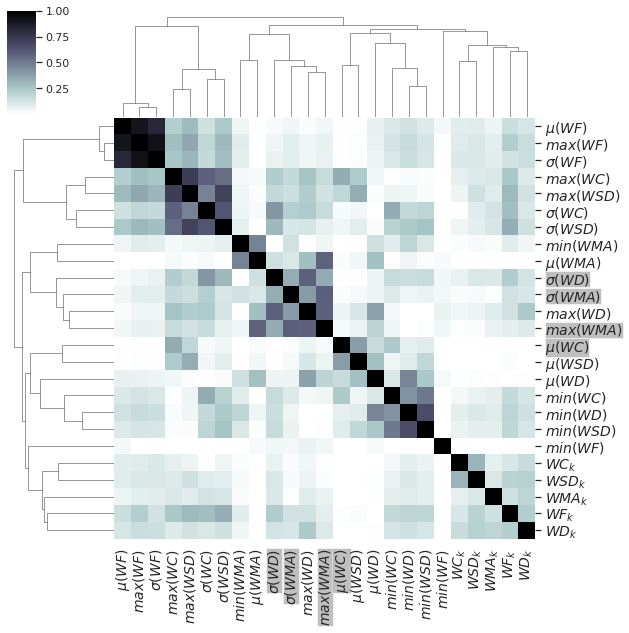

In [138]:
clustergrid = sns.clustermap(corr_mat, cmap='bone_r',figsize=(8, 8))

row_indices = clustergrid.dendrogram_row.reordered_ind
new_names = [cn[i] for i in row_indices]

clustergrid.ax_heatmap.set_xticklabels(new_names, rotation=90,fontsize=14)
clustergrid.ax_heatmap.set_yticklabels(new_names,rotation=0,fontsize=14)


clustergrid.ax_heatmap.get_xticklabels()[13].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
clustergrid.ax_heatmap.get_xticklabels()[9].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
clustergrid.ax_heatmap.get_xticklabels()[10].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
clustergrid.ax_heatmap.get_xticklabels()[12].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))

clustergrid.ax_heatmap.get_yticklabels()[13].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
clustergrid.ax_heatmap.get_yticklabels()[9].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
clustergrid.ax_heatmap.get_yticklabels()[10].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
clustergrid.ax_heatmap.get_yticklabels()[12].set_bbox(dict(facecolor="gray", alpha=0.5,pad=0.1))
plt.savefig('../../Figure/dendo-matrix.jpeg', dpi=300, bbox_inches = "tight")

## Leiden Community Detection

In [108]:
def change_list_dict(comm_dict):
    # Initialize dictionary with normal values
    dict_with_normal = {}
    # # Iterate through dictionary and join list items
    for key, value in comm_dict.items():
        dict_with_normal[key] = ''.join(str(x) for x in value)

    return dict_with_normal

def leiden_comm_detection(corr_mat):
    # create a graph object from the correlation matrix
    G = networkx.to_networkx_graph(corr_mat, create_using=networkx.Graph())  
    # run the Leiden algorithm
    communities = algorithms.leiden(G, weights='weight')
    community_dict = communities.to_node_community_map()
    leiden_community_dict = change_list_dict(community_dict)
    leiden_comms={}
    for node_index, comm_id in leiden_community_dict.items():
        if comm_id in leiden_comms.keys():
            leiden_comms[comm_id].append(node_index)
        else:
            leiden_comms.setdefault(comm_id, [node_index])
    nodes_leiden_ordered = [node for comm in leiden_comms.values() for node in comm]
        
    adjacency_matrix = np.zeros_like(corr_mat)
    for i in range(corr_mat.shape[0]):
        for j in range(corr_mat.shape[0]):
            r = nodes_leiden_ordered.index(i)
            c = nodes_leiden_ordered.index(j)
            adjacency_matrix[r,c] = corr_mat[i,j] 
            
    return G, leiden_community_dict, nodes_leiden_ordered, adjacency_matrix

In [109]:
G_leiden, leiden_community_dict, nodes_leiden_ordered, adjacency_matrix_leiden = leiden_comm_detection(corr_mat)

In [110]:
### Plotting

n = []
for i in range(len(X)):
    n.append(X[i].name)

dicts_leiden = {}
keys = range(len(X))
values = n
for i in keys:
        dicts[i] = values[i]
        
new_list_label_leiden = sorted(dicts.items(), key=lambda pair: nodes_leiden_ordered.index(pair[0]))

new_list_leiden = []
for i in range(len(new_list_label_leiden)):
    new_list_leiden.append(new_list_label_leiden[i][1])
    
new_list_leiden.insert(0, 0)    

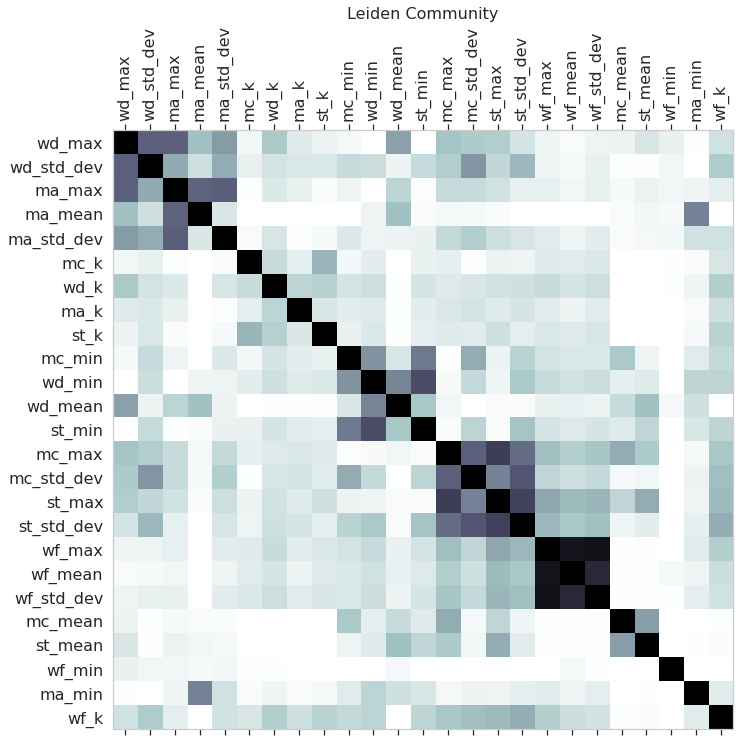

In [114]:
f,(ax) = plt.subplots(1,1,figsize=(10,10))
ax.matshow(adjacency_matrix_leiden,cmap='bone_r',  aspect='auto')


ax.grid(False)
ax.set_title('Leiden Community')
ax.set_xticklabels(new_list_leiden,rotation=90)
ax.xaxis.set_major_locator(plt.MaxNLocator(25))
ax.set_yticklabels(new_list_leiden)
ax.yaxis.set_major_locator(plt.MaxNLocator(25))

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)
f.savefig('../../Figure/leiden.jpeg', dpi=300, bbox_inches = "tight")

In [92]:
# Initialize dictionary with normal values
dict_with_normal = {}

# Iterate through dictionary and join list items
for key, value in community_dict.items():
    dict_with_normal[key] = ''.join(str(x) for x in value)

# Print new dictionary with normal values
print(dict_with_normal)


{11: '0', 13: '0', 16: '0', 17: '0', 18: '0', 4: '1', 14: '1', 19: '1', 24: '1', 0: '2', 10: '2', 12: '2', 20: '2', 1: '3', 3: '3', 21: '3', 23: '3', 6: '4', 7: '4', 8: '4', 2: '5', 22: '5', 9: '6', 5: '7', 15: '8'}
